Installations et imports

In [ ]:
# Installer les packages nécessaires (à exécuter une seule fois)
!pip install transformers datasets sentencepiece torch scikit-learn pandas matplotlib seaborn

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import CamembertTokenizer, CamembertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
print("="*50)
print("VÉRIFICATION GPU")
print("="*50)
print(f"PyTorch version: {torch.__version__}")
print(f"GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Nom du GPU: {torch.cuda.get_device_name(0)}")
    print(f"Mémoire GPU totale: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Nombre de GPUs: {torch.cuda.device_count()}")
else:
    print("⚠️ Attention: GPU non disponible, l'entraînement sera sur CPU")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilisé: {device}")
print("="*50)

VÉRIFICATION GPU
PyTorch version: 2.2.2
GPU disponible: True
Nom du GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Mémoire GPU totale: 4.29 GB
Nombre de GPUs: 1
Device utilisé: cuda


Charger la dataset

DatasetDict({
    train: Dataset({
        features: ['media', 'post', 'fake'],
        num_rows: 6645
    })
    test: Dataset({
        features: ['media', 'post', 'fake'],
        num_rows: 2849
    })
})
Exemple: {'media': 'unknown', 'post': "Sénatoriales : les résultats des élections.La moitié des postes de sénateurs ont été renouvelés ce dimanche. Et les résultats du mouvement d'Emmanuel Macron ne sont pas bons. Retrouvez les résultats des élections sénatoriales partielles.", 'fake': 0}
0    3400
1    3245
Name: count, dtype: int64


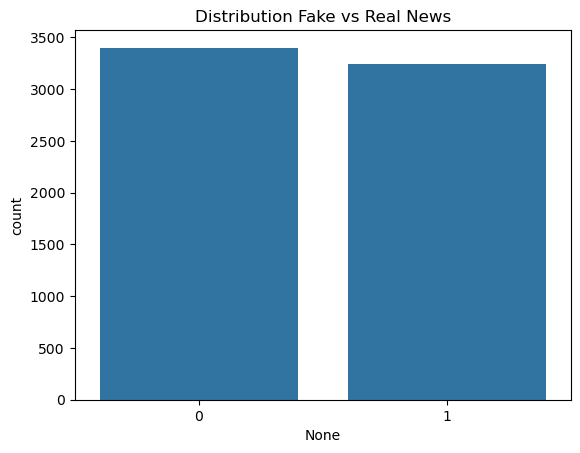

In [ ]:
dataset = load_dataset("FrancophonIA/FrenchFakeNewsDetector")
print(dataset)
print("Exemple:", dataset["train"][0])

# Distribution des classes
labels = pd.Series(dataset["train"]["fake"])
print(labels.value_counts())

sns.countplot(x=labels)
plt.title("Distribution Fake vs Real News")
plt.show()


In [ ]:
# Avant la tokenisation, vérifiez la longueur moyenne
lengths = [len(tokenizer.encode(text)) for text in dataset["train"]["post"][:1000]]
print(f"Longueur moyenne: {np.mean(lengths)}")
print(f"Longueur max: {np.max(lengths)}")
print(f"90e percentile: {np.percentile(lengths, 90)}")

Longueur moyenne: 209.898
Longueur max: 4952
90e percentile: 530.0


Prétraitement et tokenisation

In [ ]:
# Prétraitement simple
def preprocess(example):
    example["post"] = str(example["post"])
    return example

dataset = dataset.map(preprocess)

# Tokenisation CamemBERT
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

def tokenize_function(example):
    return tokenizer(
        example["post"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Préparer labels et format PyTorch
tokenized_dataset = tokenized_dataset.rename_column("fake", "labels")
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print(f"Train size: {len(tokenized_dataset['train'])}")
print(f"Test size: {len(tokenized_dataset['test'])}")

Map:   0%|          | 0/6645 [00:00<?, ? examples/s]

Map:   0%|          | 0/2849 [00:00<?, ? examples/s]

Train size: 6645
Test size: 2849


Charger le modèle sur GPU

In [ ]:
model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base",
    num_labels=2
).to(device)

# Vérifier que le modèle est sur GPU
print(f"Modèle chargé sur: {next(model.parameters()).device}")


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modèle chargé sur: cuda:0


Définir les TrainingArguments

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=20,  # ✅ Augmenté à 20
    per_device_eval_batch_size=20,   # ✅ Augmenté à 20
    gradient_accumulation_steps=2,   # ✅ Batch effectif = 40
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    dataloader_num_workers=0,
    report_to="none"
)

Fonction métriques

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}


Entraînement avec Trainer

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.333900,0.038504,0.992980
2,0.030700,0.030839,0.993331
3,0.010200,0.026911,0.994384


TrainOutput(global_step=501, training_loss=0.08721920097164973, metrics={'train_runtime': 5133.2035, 'train_samples_per_second': 3.884, 'train_steps_per_second': 0.098, 'total_flos': 2622559444300800.0, 'train_loss': 0.08721920097164973, 'epoch': 3.0})

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.026911329478025436, 'eval_accuracy': 0.9943839943839944, 'eval_runtime': 100.2015, 'eval_samples_per_second': 28.433, 'eval_steps_per_second': 1.427, 'epoch': 3.0}


In [ ]:
# Prédictions détaillées
predictions = trainer.predict(tokenized_dataset["test"])
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = tokenized_dataset["test"]["labels"]

print("\n📊 Rapport de classification:")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))


📊 Rapport de classification:
              precision    recall  f1-score   support

        Real       0.99      1.00      0.99      1441
        Fake       1.00      0.99      0.99      1408

    accuracy                           0.99      2849
   macro avg       0.99      0.99      0.99      2849
weighted avg       0.99      0.99      0.99      2849



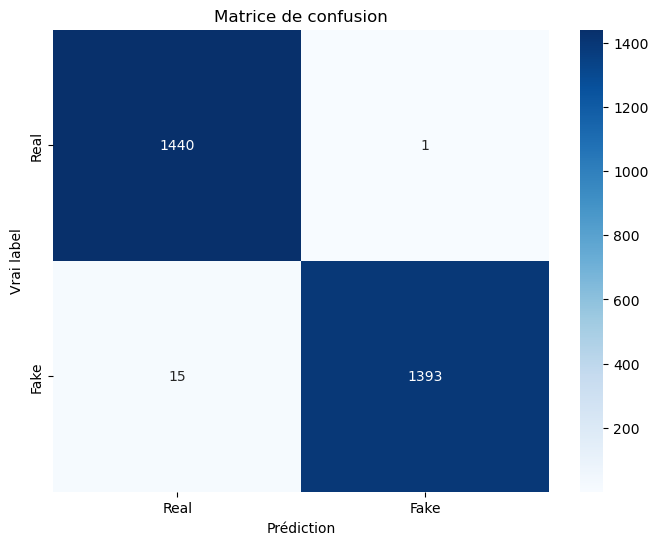


💾 Sauvegarde du modèle...
✓ Modèle sauvegardé dans './camembert_fake_news_detector'


In [ ]:
# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Real", "Fake"], 
            yticklabels=["Real", "Fake"])
plt.title("Matrice de confusion")
plt.ylabel("Vrai label")
plt.xlabel("Prédiction")
plt.show()

# Sauvegarde
print("\n💾 Sauvegarde du modèle...")


Sauvegarder le modèle entraîné

In [ ]:
# Sauvegarde pour réutilisation
model.save_pretrained("./camembert_fakenews_model")
tokenizer.save_pretrained("./camembert_fakenews_model")


('./camembert_fakenews_model\\tokenizer_config.json',
 './camembert_fakenews_model\\special_tokens_map.json',
 './camembert_fakenews_model\\sentencepiece.bpe.model',
 './camembert_fakenews_model\\added_tokens.json')

Chargement du modèle 

In [ ]:
from transformers import CamembertForSequenceClassification, CamembertTokenizer

loaded_tokenizer = CamembertTokenizer.from_pretrained("./camembert_fakenews_model")
loaded_model = CamembertForSequenceClassification.from_pretrained("./camembert_fakenews_model").to(device)


Tester modèle

In [ ]:
# Texte à tester
text_example = """
eur de Cleveland arrêté et inculpé pour « utilisation de Facebook »
Après avoir fait au moins une victime par balle et des millions d’autres en les obligeant à aller sur Facebook pour le suivre, le tueur de Cleveland, Steve Stephens, a enfin été arrêté et a été inculpé pour « utilisation de réseau social moisi ». La rédaction du journal revient sur cette bonne nouvelle.

« Tuer des gens c’est une chose mais utiliser Facebook en est une autre »
Nous avons pu interroger le chef de la police de Cleveland, Lance Maring, qui espère que l’arrestation de cet homme servira d’exemple :

« Je tiens à féliciter mes hommes pour leur travail ainsi que toutes les personnes qui n’ont pas hésité à signaler les déplacements de ce criminel. Il y a des limites à ne pas franchir, nous sommes les États-Unis d’Amérique : posséder une arme à feu et tuer des gens c’est une chose, mais utiliser Facebook en est une autre. Nous espérons que cette histoire servira d’exemple pour que tous ceux qui essaieront d’entraîner des jeunes sur ce réseau social malfaisant comprennent qu’ils font une grosse erreur. Sachez que nous vous surveillons et que nous vous arrêterons ainsi que le chef de votre secte, Mark Zuckerberg. Le temps où c’était cool d’avoir un profil Facebook est révolu, dorénavant vous êtes des parias ! »

Il risque 30 ans de prison et l’obligation d’aller sur Twitter
D’après nos informations, Steve Stephens devrait écoper au minimum, si la justice de Cleveland est clémente, de 30 ans de prison ferme (1 an pour son meurtre et 29 ans pour avoir utilisé Facebook).

Il sera également soumis à une obligation d’utiliser seulement Twitter à sa sortie, si ce dernier n’a pas disparu de la surface de la Terre d’ici là. Selon les autorités, cette condamnation lui permettra de se réinsérer plus facilement dans la société puisqu’il y rencontrera des personnes qui lui ressemblent, c’est-à-dire sans code moral et sans avenir.

Plus qu’à espérer maintenant qu’il ne gâche pas tout et qu’il valide cette condamnation en l’approuvant par un « j’aime ».
"""

# Fonction de prédiction
def predict_post(text):
    inputs = loaded_tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=512).to(device)
    outputs = loaded_model(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()
    return "Fake" if pred == 1 else "Real"

# Tester le texte
result = predict_post(text_example)
print("Prediction:", result)


Prediction: Fake
